In [14]:
import boto3
import base64
from botocore.exceptions import ClientError
import json
import os
import pandas as pd
import sys
from io import StringIO 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
def get_secret():

    secret_name = 'arn:aws:secretsmanager:us-east-2:363247502029:secret:AWSAccessKeys-6eo7IN'
    region_name = "us-east-2"
    secret = ''

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    # In this sample we only handle the specific exceptions for the 'GetSecretValue' API.
    # See https://docs.aws.amazon.com/secretsmanager/latest/apireference/API_GetSecretValue.html
    # We rethrow the exception by default.

    get_secret_value_response = client.get_secret_value(
        SecretId=secret_name
    )
    # Decrypts secret using the associated KMS CMK.
    # Depending on whether the secret is a string or binary, one of these fields will be populated.
    if 'SecretString' in get_secret_value_response:
        secret = get_secret_value_response['SecretString']
    else:
        secret = base64.b64decode(get_secret_value_response['SecretBinary'])
    return json.loads(secret)
    # Your code goes here. 

In [16]:
# get your credentials from environment variables
secrets = get_secret()
aws_id = secrets['AWS_ACCESS_KEY']
aws_secret = secrets['AWS_SECRET_KEY']

client = boto3.client('s3', aws_access_key_id=aws_id,aws_secret_access_key=aws_secret)

bucket_name = 'airline-test'
# s3://airline-test/Dataset_demand_forecast2.csv
object_key = 'Dataset_demand_forecast2.csv'
csv_obj = client.get_object(Bucket=bucket_name, Key=object_key)
body = csv_obj['Body']
csv_string = body.read().decode('utf-8')

# vAR_df1 = pd.read_csv(StringIO(csv_string))

ClientError: An error occurred (InvalidAccessKeyId) when calling the GetObject operation: The AWS Access Key Id you provided does not exist in our records.

In [4]:
df1=pd.read_csv(StringIO(csv_string))

In [5]:
df1.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Product,Customer,Booking,Revenue,Date_of_Journey1,m
0,Air Arabia,01/01/21,Sharjah,New Ras AI Khaimah,SHJ ? RKT,22:20,01:10,2h 50m,non-stop,No info,First Class,Rare Flyer,7,3897,01/12/21,1
1,Emirates,01/01/21,Abu Dhabi,Sharjah,AUH ? IXR ? BBI ? SHJ,05:50,13:15,7h 25m,2 stops,No info,Economy,First Flyer,4,7662,01/05/21,1
2,Flydubai,01/01/21,Ras AI Khaimah,Cochin,RKT ? LKO ? BOM ? COK,09:25,04:25,19h,2 stops,No info,Business,First Flyer,6,13882,01/04/21,1
3,Air Arabia,01/01/21,Abu Dhabi,Sharjah,AUH ? NAG ? SHJ,18:05,23:30,5h 25m,1 stop,No info,Business,First Flyer,7,6218,01/06/21,1
4,Air Arabia,01/01/21,Sharjah,New Ras AI Khaimah,SHJ ? NAG ? RKT,16:50,21:35,4h 45m,1 stop,No info,Business,Rare Flyer,9,13302,01/07/21,1


In [6]:
df = pd.DataFrame(df1.groupby(["Airline", "Date_of_Journey", "Source", "Destination", "Product", "Customer"])["Booking", "Revenue"].sum()).reset_index()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  if __name__ == '__main__':


In [7]:
df = df[df['Airline'] == "Flydubai"]
df

,Airline,Date_of_Journey,Source,Destination,Product,Customer,Booking,Revenue
4268,Flydubai,01/01/21,Abu Dhabi,Sharjah,Business,First Flyer,9,14781
4269,Flydubai,01/01/21,Abu Dhabi,Sharjah,Business,Frequent Flyer,10,7757
4270,Flydubai,01/01/21,Abu Dhabi,Sharjah,Business,Rare Flyer,5,22076
4271,Flydubai,01/01/21,Abu Dhabi,Sharjah,Economy,First Flyer,12,26115
4272,Flydubai,01/01/21,Abu Dhabi,Sharjah,Economy,Rare Flyer,2,8366
...,...,...,...,...,...,...,...,...
11744,Flydubai,31/12/21,Sharjah,New Ras AI Khaimah,Business,First Flyer,7,15025
11745,Flydubai,31/12/21,Sharjah,New Ras AI Khaimah,Business,Rare Flyer,7,12284
11746,Flydubai,31/12/21,Sharjah,New Ras AI Khaimah,First Class,First Flyer,8,26890
11747,Flydubai,31/12/21,Sharjah,New Ras AI Khaimah,First Class,Rare Flyer,4,11455


In [8]:
df['Date_of_Journey']=pd.to_datetime(df['Date_of_Journey'])
df.dtypes

Airline                    object
Date_of_Journey    datetime64[ns]
Source                     object
Destination                object
Product                    object
Customer                   object
Booking                     int64
Revenue                     int64
dtype: object

In [9]:
df = pd.DataFrame(df[['Date_of_Journey', 'Revenue']].groupby('Date_of_Journey')['Revenue'].sum(), columns = ["Revenue"])

In [10]:
from statsmodels.tsa.stattools import adfuller
def adf_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
adf_test(df['Revenue'])

1. ADF :  -5.530801685940344
2. P-Value :  1.7894248874013898e-06
3. Num Of Lags :  2
4. Num Of Observations Used For ADF Regression: 362
5. Critical Values :
	 1% :  -3.448544133483233
	 5% :  -2.8695574079525565
	 10% :  -2.5710411593052713


In [11]:
!pip install pmdarima
from pmdarima import auto_arima
stepwise_fit = auto_arima(df['Revenue'], trace=True,
suppress_warnings=True)

     |████████████████████████████████| 1.4 MB 4.6 MB/s            
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9403.340, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9479.416, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9444.227, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9418.063, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9477.423, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9401.149, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9402.250, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9421.971, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=9399.405, Time=0.44 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=9419.616, Time=0.10 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=9405.974, Time=0.49 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=9399.860, Time=0.51 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   

In [12]:
print(df.shape)
train=df.iloc[:-30]
test=df.iloc[-30:]
print(train.shape,test.shape)

(365, 1)
(335, 1) (30, 1)


In [13]:
# from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.arima.model as stats
model = stats.ARIMA(df['Revenue'], order = (3,1,1))
model_fit=model.fit()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [14]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  365
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -4692.283
Date:                Wed, 22 Dec 2021   AIC                           9394.566
Time:                        05:59:14   BIC                           9414.052
Sample:                    01-01-2021   HQIC                          9402.311
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4794      0.054      8.799      0.000       0.373       0.586
ar.L2          0.0556      0.062      0.899      0.369      -0.066       0.177
ar.L3          0.1212      0.052      2.339      0.019       0.020       0.223
ma.L1         -0.9775      0.017    -58.475      0.000      -1.010      -0.945
sigma2      9.898e+09   1.15e-12   8.58e+21      0.000     9.9e+09     9.9e+09
===================================================================================
Ljung-Box (Q):                       73.62   Jarque-Bera (JB):                30.88
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             0.12
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.25e+37. Standard errors may be unstable.
"""

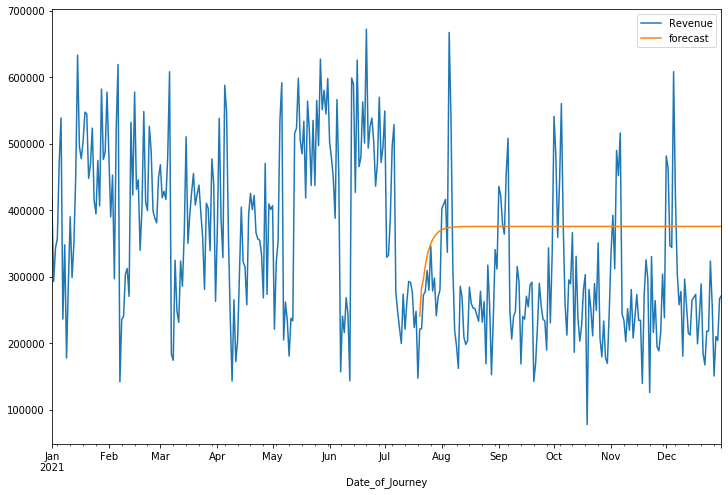

In [15]:
df['forecast']=model_fit.predict(start=200,end=365,dynamic=True)
df[['Revenue','forecast']].plot(figsize=(12,8))

In [16]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df['Revenue'],order=(3, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


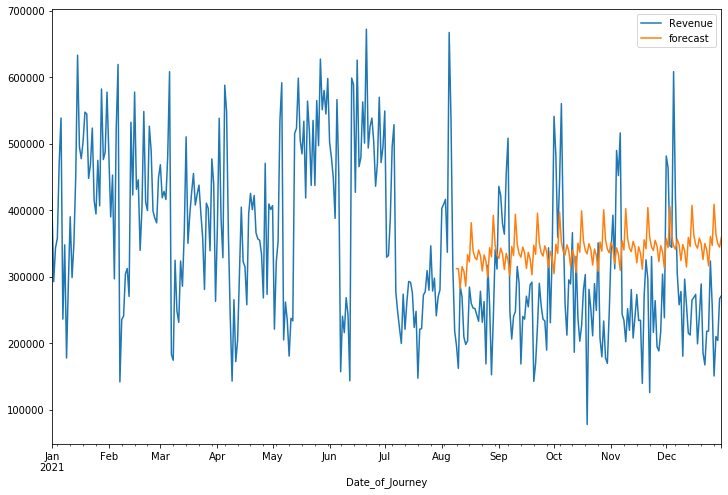

In [17]:
df['forecast']=results.predict(start=220,end=364,dynamic=True)
df[['Revenue','forecast']].plot(figsize=(12,8))